In [1]:
import numpy as np
import nibabel as nib
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import monai
from monai.transforms import *
from monai.utils import set_determinism
from monai.data import Dataset, PatchIterd, GridPatchDataset, CacheDataset, PersistentDataset, DataLoader
from monai.transforms import Resample
import sys
import psutil
device = f'cuda:0'

Load all the filenames

In [2]:
path_X = '/mnt/volume1/hecktor_2022/hecktor2022/imagesTr'
path_Y = '/mnt/volume1/hecktor_2022/hecktor2022/labelsTr'
files_Y = sorted(os.listdir(path_Y))

filenames = []
for file_Y in files_Y:
    file_CT = file_Y.split('.')[0]+'__CT.nii.gz'
    file_PT = file_Y.split('.')[0]+'__PT.nii.gz'
    file_GT = file_Y
    filenames.append({'CT':f'{path_X}/{file_CT}',
                      'PT':f'{path_X}/{file_PT}',
                      'GT':f'{path_Y}/{file_GT}'})

Make the dataset, and define the transformation pipeline. We will resize all images such that axial slices are 128x128, and adjust the CT and GT images using affine matrices to correspond to the PT image.

* Note that `ResampleToMatchd` assumes that `data` contains (for each `key` in `['CT', 'GT']` below) a `{key}_meta_dict`  dictionary that contains an `affine` field. That way, both the `CT` and the `GT` image can be resampled to the `PT` image in the `ResampleToMatchd` function in the `transform` below. This requires `image_only=False` when loading the data using `LoadImaged` so that the meta_dict information can be loaded as well.

* `bilinear` is used for CT (best interpolation) but `nearest` is used for the GT mask to ensure that the segmentation labels remain discrete

In [3]:
fn_keys = ['CT', 'PT', 'GT']
CT_min = -525
CT_max = 1250
transform= Compose([LoadImaged(fn_keys, image_only=False),
                    ScaleIntensityRanged('CT', a_min=CT_min, a_max=CT_max, b_min=0, b_max=1, clip=True),
                    AddChanneld(fn_keys),
                    ResampleToMatchd(['CT', 'GT'],  key_dst='PT', mode=['bilinear', 'nearest']),
                    Resized(fn_keys, (128,128,-1)),
                    ToTensord(['CT', 'PT'], dtype=torch.float32),
                    ToTensord('GT', dtype=torch.long),
                    ConcatItemsd(['CT', 'PT'], 'X'),
                    DeleteItemsd(['CT', 'PT']),
                    Transposed(['X', 'GT'], (3,0,1,2)),
                    ToDeviced(['X', 'GT'], device)
                    ])

This cache dataset stores all the data in memory, so the pipeline does not need to be executed each training iteration

In [4]:
ds = CacheDataset(data=filenames[:20], transform=transform)

Loading dataset: 100%|███████████████████████████| 20/20 [01:03<00:00,  3.17s/it]


Based on the above, should take about 22 minutes to load full data into the cache (neglibible compared to training time). Lets see how much memory this takes up

In [5]:
print(f'RAM memory % used: {psutil.virtual_memory()[3]/1e9} GB')
print(f'RAM memory % used for total data: {psutil.virtual_memory()[3]/1e9 *len(filenames)/20} GB')

RAM memory % used: 3.218726912 GB
RAM memory % used for total data: 84.33064509440001 GB


For the total dataset, this is totally manageable by the RONIN computers we have (244GB is available with 4GPUs). Now lets make a dataloader:

In [6]:
dl = DataLoader(ds, batch_size=1, num_workers=0)

Define model

In [7]:
model = monai.networks.nets.UNet(spatial_dims=2, in_channels=2, out_channels=3,
                                 channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2)).to(device)

Train, looping over individual 2D slices:

In [8]:
n_epochs=10

In [ ]:
'''Training'''
def train_batch(model, data, optimizer, criterion):
    model.train()
    x_all, y_all = data['X'][0], data['GT'][0]
    total_loss = 0
    for x, y in zip(x_all, y_all):
        x = x[None]
        _y = model(x)
        optimizer.zero_grad()
        loss = criterion(_y,y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return loss.item()

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.,1.,1.]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
for ex in range(n_epochs):
    N = len(dl)
    print(f'Epoch {ex}')
    for bx, data in enumerate(dl):
        loss = train_batch(model, data, optimizer, criterion)
        losses.append(loss)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6


# Predictions

Plot some model predictions

In [ ]:
s = 4
slc = 54

In [ ]:
plt.subplots(1,4,figsize=(18,4))
plt.subplot(141)
plt.pcolormesh(ds[s]['X'][slc][0].cpu())
plt.subplot(142)
plt.pcolormesh(ds[s]['X'][slc][1].cpu())
plt.subplot(143)
plt.pcolormesh(ds[s]['GT'][slc][0].cpu())
plt.colorbar()
plt.subplot(144)
plt.pcolormesh(torch.max(model(ds[s]['X'][slc][None]), axis=1).indices.cpu()[0])
plt.colorbar()

# Extra

In [171]:
CT = ds[4]['X'][:,0].cpu()
PT = ds[4]['X'][:,1].cpu()
GT = ds[4]['GT'][:,0].cpu()

In [172]:
np.unique(GT)

array([0, 1, 2])

In [173]:
np.unique(np.where(GT)[0])

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

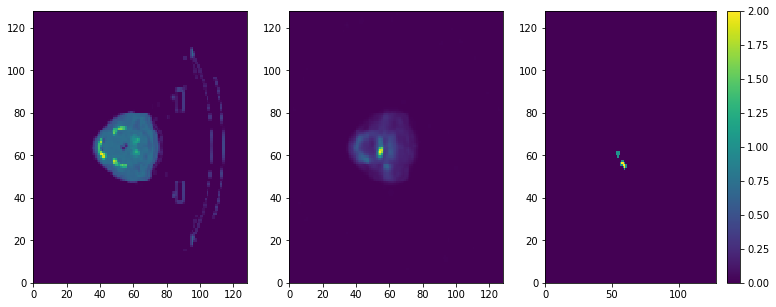

In [180]:
plt.subplots(1,3,figsize=(13,5))
plt.subplot(131)
plt.pcolormesh(CT[56])
plt.subplot(132)
plt.pcolormesh(PT[56])
plt.subplot(133)
plt.pcolormesh(GT[56])
plt.colorbar()

# Alternative to the Above Using SITK

In [ ]:
import SimpleITK as sitk

In [ ]:
ctimg = sitk.ReadImage(filenames[2]['CT'], imageIO="NiftiImageIO")
ptimg = sitk.ReadImage(filenames[2]['PT'], imageIO="NiftiImageIO") 
gtimg = sitk.ReadImage(filenames[2]['GT'], imageIO="NiftiImageIO") 

In [ ]:
resampled_ctimg = sitk.Resample(ctimg, ptimg, interpolator=sitk.sitkLinear, defaultPixelValue=-1024)
resampled_gtimg = sitk.Resample(gtimg, ptimg, interpolator=sitk.sitkNearestNeighbor, defaultPixelValue=0)

In [ ]:
resampled_ctimg

In [16]:
im = sitk.GetArrayFromImage(resampled_ctimg)

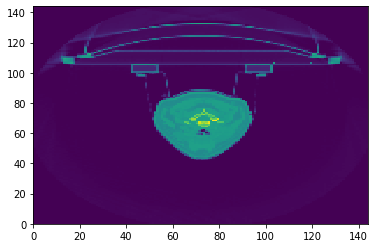

In [20]:
plt.pcolormesh(im[50])